In [17]:
import pandas as pd
import os, re
import numpy as np

In [18]:
# Specify the experiment type, i.e., 0: load stimulus, 1: resource stimulus
exp_type = 0

In [19]:
# Change the work directory to the parent
try:
    if chdir:
        pass
except:
    current_dir = os.getcwd()
    os.chdir(current_dir +"/..")
    os.path.abspath(os.curdir)

In [20]:
chdir = True

In [21]:
# Metadata for specific SFC configurations
exp_ls = "exp10"
exp_rs = "exp-4-1-1"
vnfs = ["flow_tracker.csv", "nf_router.csv", "ndpi_stats.csv", "payload_scan.csv", "bridge.csv"]

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 11})

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

In [23]:
# this function is good for long_exp
def parse_seq(exp_type, exp_num, file, index=5):
    "Parse sequential data, specialized for the TX/RX/Latency experiments"
    tmp = []
    
    if file.startswith("latency.csv"):
        with open(os.path.join("..\\dag-2\\data", exp_type, exp_num, file)) as f:
            lines = f.readlines()[4:] if exp_type == "load_stimulus" else f.readlines()
            for line in lines:
                value = float(line.strip()) /1000
                tmp.append(value)
                
    else:
        with open(os.path.join("..\\dag-2\\data", exp_type, exp_num, file)) as f:
            next(f)
            for l in f:
                try:
                    value = float(l.strip().split(",")[index])
                except ValueError:
                    value = "N/A"
                tmp.append(value)
                
    return tmp

In [24]:
# this function is good for exp1-exp10, pay attention the latency feature
def parse_seq(exp_type, exp_num, file, index=5):
    "Parse sequential data, specialized for the TX/RX/Latency experiments"
    tmp = []
    
    if file.startswith("latency.csv"):
        with open(os.path.join("..\\dag-2\\data", exp_type, exp_num, file)) as f:
            lines = f.readlines()[4:] if exp_type == "load_stimulus" else f.readlines()
            for i in range(len(lines)):
                if i % 2 != 0:  # Check if the index is odd
                    value = float(lines[i].strip()) / 1000
                    tmp.append(value)
    else:
        with open(os.path.join("..\\dag-2\\data", exp_type, exp_num, file)) as f:
            next(f)
            for l in f:
                try:
                    value = float(l.strip().split(",")[index])
                except ValueError:
                    value = "N/A"
                tmp.append(value)
                
    return tmp

In [25]:
def parse_reg(exp_type, exp_num, file, stat_name, index=1):
    "Parse the Perf data"
    stat = []
    with open(os.path.join("..\\dag-2\\data", exp_type, exp_num, file)) as f:
        for line in f:
            if re.search(stat_name, line):
                stat.append(line.strip().split(',')[index])
    
    return list(map(lambda x:float(x), stat[:-1]))


In [26]:
latency = parse_seq("load_stimulus", exp_ls, "latency.csv")
len(latency)

209

In [27]:
tx_stats = parse_seq("load_stimulus", exp_ls, "tx_stats.csv")
len(tx_stats)

209

In [28]:
rx_stats = parse_seq("load_stimulus", exp_ls, "rx_stats.csv")
len(rx_stats)

209

In [29]:
flow_tracker_instructions = parse_reg("load_stimulus", exp_ls, "flow_tracker.csv", "instructions", 1)
len(flow_tracker_instructions)

208

In [30]:
features = ["instructions", "branches,", "branch-misses,", "branch-load-misses,", "cache-misses", \
            "cache-references", ",cycles,", "L1-dcache-load-misses", "L1-dcache-loads", "LLC-load-misses", \
            "LLC-stores", "LLC-loads",]

In [32]:
def make_df():
    tmp = []
    dic = dict()

    tx_stats = parse_seq("load_stimulus", exp_ls, "tx_stats.csv")
    rx_stats = parse_seq("load_stimulus", exp_ls, "rx_stats.csv")
    latency = parse_seq("load_stimulus", exp_ls, "latency.csv")

    seq_length = min(len(tx_stats), len(rx_stats), len(latency), len(parse_reg("load_stimulus", exp_ls, "flow_tracker.csv", "instructions", 1)))

    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]

    for f in features:
        for v in vnfs:
            tmp = parse_reg("load_stimulus", exp_ls, v, f, 1)
            tmp = tmp[:seq_length]
            if len(tmp) < seq_length:
                tmp = np.pad(tmp, (0, seq_length - len(tmp)), mode='constant')
            dic[v.split(".")[0] + "_" + f.replace(",", "")] = tmp

    return pd.DataFrame(dic)


In [33]:
df = make_df()
df

,input_rate,output_rate,latency,flow_tracker_instructions,nf_router_instructions,ndpi_stats_instructions,payload_scan_instructions,bridge_instructions,flow_tracker_branches,nf_router_branches,...,flow_tracker_LLC-stores,nf_router_LLC-stores,ndpi_stats_LLC-stores,payload_scan_LLC-stores,bridge_LLC-stores,flow_tracker_LLC-loads,nf_router_LLC-loads,ndpi_stats_LLC-loads,payload_scan_LLC-loads,bridge_LLC-loads
0,182.445627,180.775877,12.755,1.037978e+10,1.089131e+10,1.108793e+10,1.130707e+10,1.111257e+10,2.015738e+09,2.153262e+09,...,432784.0,1183524.0,417856.0,398607.0,865668.0,1041866.0,1575525.0,1236561.0,980546.0,1782274.0
1,517.333568,528.361355,9.923,1.038251e+10,1.101216e+10,1.119050e+10,1.122600e+10,1.101271e+10,2.026854e+09,2.146413e+09,...,432364.0,1184965.0,419260.0,395816.0,871251.0,1036851.0,1584479.0,1252451.0,976562.0,1763460.0
2,528.121790,528.142645,7.485,9.708048e+09,1.101749e+10,1.119269e+10,1.131424e+10,1.090707e+10,1.894434e+09,2.157420e+09,...,432152.0,1203903.0,426734.0,394560.0,865248.0,1054742.0,1639345.0,1299234.0,1004781.0,1777690.0
3,528.311942,528.287280,8.630,1.038328e+10,1.101421e+10,1.119201e+10,1.128479e+10,1.102964e+10,2.026656e+09,2.159709e+09,...,427742.0,1182173.0,417541.0,388303.0,846243.0,1036526.0,1616592.0,1281172.0,981408.0,1781858.0
4,528.178659,528.178832,10.397,1.023725e+10,1.101496e+10,1.119075e+10,1.115471e+10,1.094596e+10,2.005872e+09,2.171494e+09,...,436471.0,1181187.0,418228.0,398747.0,858661.0,1039968.0,1590057.0,1251391.0,988584.0,1779241.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,528.283866,528.310672,9.562,1.031009e+10,1.093378e+10,1.110977e+10,1.122794e+10,1.110377e+10,2.016260e+09,2.159013e+09,...,436456.0,1169500.0,414855.0,397096.0,847314.0,1038939.0,1611844.0,1275439.0,995808.0,1827342.0
204,528.362518,528.365257,5.737,9.628824e+09,1.081910e+10,1.099386e+10,1.122211e+10,1.110150e+10,1.849084e+09,2.142805e+09,...,430341.0,1174868.0,417959.0,391403.0,871231.0,1033653.0,1611079.0,1285356.0,985008.0,1809561.0
205,528.318418,528.325632,8.102,1.038571e+10,1.084298e+10,1.101595e+10,1.131260e+10,1.109957e+10,2.004454e+09,2.146657e+09,...,437016.0,1188435.0,420926.0,396709.0,866713.0,1046060.0,1623921.0,1287205.0,991940.0,1797720.0
206,528.322325,528.309485,12.099,1.038598e+10,1.094590e+10,1.111394e+10,1.130293e+10,1.109531e+10,2.017026e+09,2.161594e+09,...,437706.0,1188273.0,421399.0,394818.0,858138.0,1040744.0,1613979.0,1285546.0,981777.0,1768861.0


<Axes: >

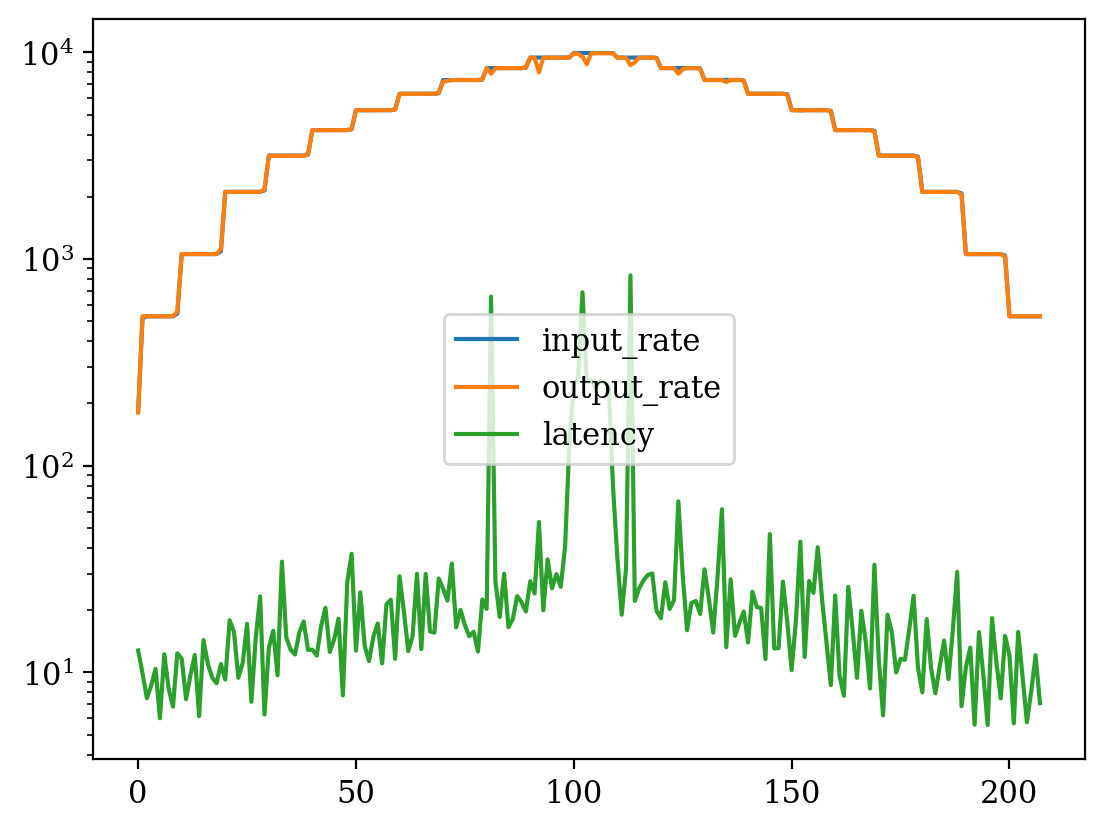

In [34]:
df.iloc[:, :3].plot(logy=True)

# Resource stimulus

In [35]:
def make_df_rl(exp_rs):
    tmp = []
    dic = dict()

    tx_stats = parse_seq("resource_stimulus", exp_rs, "tx_stats.csv")
    rx_stats = parse_seq("resource_stimulus", exp_rs, "rx_stats.csv")
    latency = parse_seq("resource_stimulus", exp_rs, "latency.csv")
    seq_length = min(len(tx_stats), len(rx_stats), len(latency), len(parse_reg("resource_stimulus", exp_rs, "flow_tracker.csv", "instructions", 1)))

    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]

    for f in features:
        for v in vnfs:
            tmp = parse_reg("resource_stimulus", exp_rs, v, f, 1)
            tmp = tmp[:seq_length]
            if len(tmp) < seq_length:
                tmp = np.pad(tmp, (0, seq_length - len(tmp)), mode='constant')
            dic[v.split(".")[0] + "_" + f.replace(",", "")] = tmp

    return pd.DataFrame(dic)

In [36]:
df_rl = make_df_rl("exp-4-1-1")
df_rl

,input_rate,output_rate,latency,flow_tracker_instructions,nf_router_instructions,ndpi_stats_instructions,payload_scan_instructions,bridge_instructions,flow_tracker_branches,nf_router_branches,...,flow_tracker_LLC-stores,nf_router_LLC-stores,ndpi_stats_LLC-stores,payload_scan_LLC-stores,bridge_LLC-stores,flow_tracker_LLC-loads,nf_router_LLC-loads,ndpi_stats_LLC-loads,payload_scan_LLC-loads,bridge_LLC-loads
0,443.821360,403.825055,9.652,9.700272e+09,9.441579e+09,1.032269e+10,1.067627e+10,9.668667e+09,1.904290e+09,1.883360e+09,...,1764613.0,4741875.0,1711668.0,1607384.0,3778843.0,2974178.0,5921571.0,4660414.0,3497313.0,5755309.0
1,1872.254187,2088.118898,9.818,9.821907e+09,9.370415e+09,1.044261e+10,1.069888e+10,9.731215e+09,1.916036e+09,1.854986e+09,...,1771261.0,4761559.0,1677303.0,1611798.0,3685661.0,2921382.0,5826895.0,4609353.0,3507716.0,5688550.0
2,2113.019446,2110.131007,20.973,9.924114e+09,9.603317e+09,1.031954e+10,1.067916e+10,9.616281e+09,1.898598e+09,1.863128e+09,...,1769394.0,4729656.0,1720675.0,1614832.0,3788841.0,2965287.0,5949994.0,4692933.0,3497009.0,5792866.0
3,2113.257248,2110.754045,9.264,9.926020e+09,9.606778e+09,1.035240e+10,1.069144e+10,9.657980e+09,1.903950e+09,1.869714e+09,...,1757920.0,4713688.0,1729923.0,1600129.0,3823611.0,2992473.0,5990913.0,4579239.0,3470618.0,5656011.0
4,2113.228876,2110.344335,9.955,9.334151e+09,9.602718e+09,1.057309e+10,1.070404e+10,9.834081e+09,1.815973e+09,1.895658e+09,...,1749016.0,4697497.0,1728269.0,1606595.0,3815136.0,2991395.0,6019186.0,4588678.0,3465218.0,5673937.0
5,2112.942288,2110.034829,10.032,9.930098e+09,9.622232e+09,1.055422e+10,1.045893e+10,8.541279e+09,1.932460e+09,1.900112e+09,...,1754604.0,4711269.0,1726039.0,1603233.0,3794432.0,2990068.0,5977349.0,4725226.0,3493163.0,5739160.0
6,2112.947704,2110.879178,15.203,9.916597e+09,9.597784e+09,1.055611e+10,1.047244e+10,9.854817e+09,1.929745e+09,1.895355e+09,...,1761140.0,4731728.0,1728943.0,1576266.0,3822696.0,2988740.0,5980358.0,4752188.0,3501029.0,5863937.0
7,2113.209274,2110.558584,8.297,9.806992e+09,9.488278e+09,1.055901e+10,1.057479e+10,9.854047e+09,1.914122e+09,1.878846e+09,...,1771244.0,4757126.0,1722187.0,1572678.0,3804092.0,2985953.0,5969149.0,4712777.0,3533032.0,5817194.0
8,2113.324669,2110.496834,11.719,9.669170e+09,9.433695e+09,1.051678e+10,1.040813e+10,9.853983e+09,1.894618e+09,1.874899e+09,...,1638235.0,4446234.0,1639734.0,1542796.0,3556027.0,2923570.0,5628887.0,4530799.0,3350706.0,5522540.0
9,2112.996534,2111.231431,11.344,9.803118e+09,9.530653e+09,1.018048e+10,1.054668e+10,9.808188e+09,1.911103e+09,1.885075e+09,...,1597753.0,4333565.0,1642447.0,1510236.0,3569585.0,2903800.0,5542497.0,4516993.0,3261560.0,5467864.0


<Axes: >

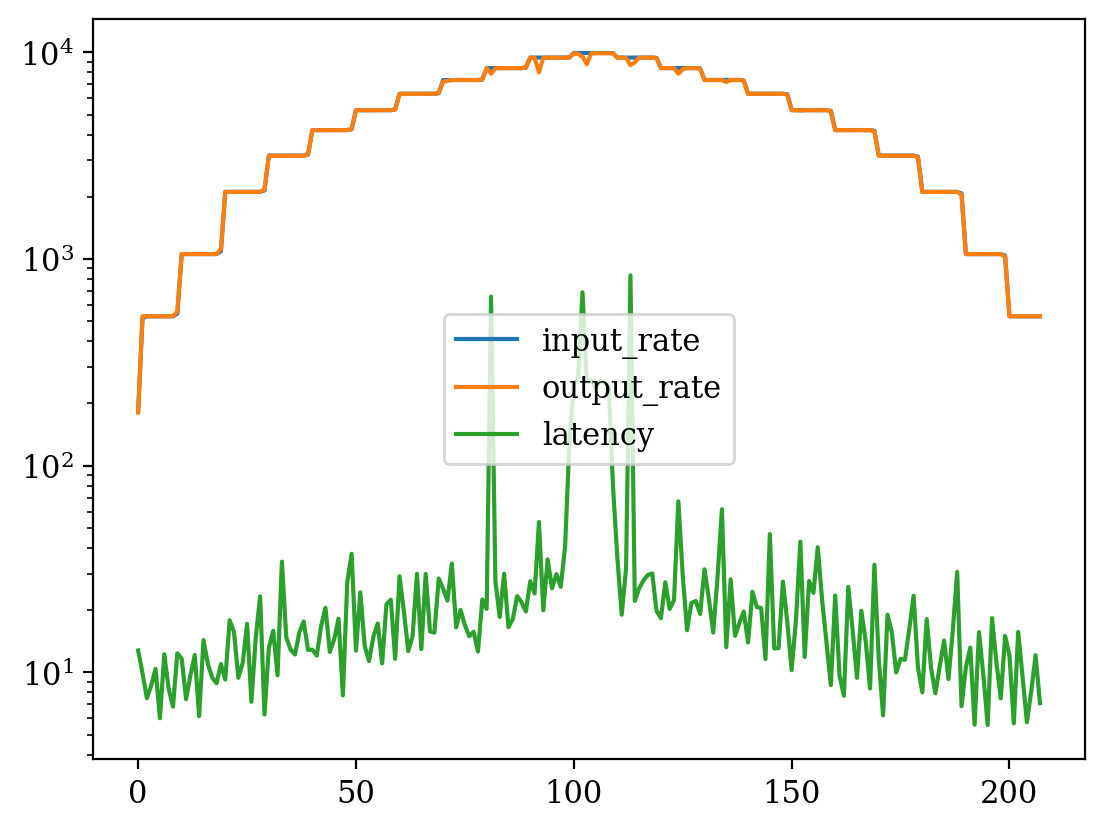

In [37]:
df.iloc[:, :3].plot(logy=True)

<Axes: >

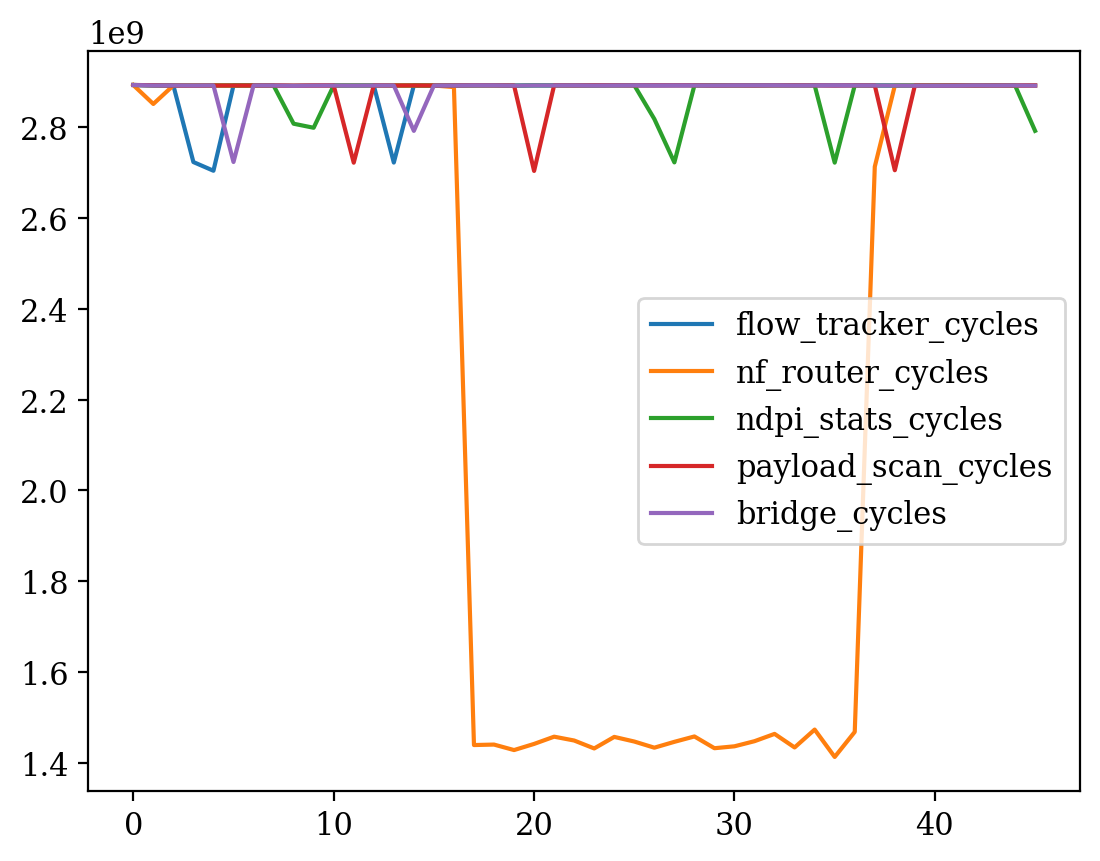

In [38]:
df_rl[["flow_tracker_cycles","nf_router_cycles","ndpi_stats_cycles","payload_scan_cycles","bridge_cycles"]].plot()